# Training and analysing our results

First, if you're no so confident about why we have to optimize our loss function, please go back to 1_fct_approx.ipynb.  
You can change ar and br by hand in order to feet our line on the dataset as much as possible. Mathematically you have to decrease the average distance between the data and you line.

## Backpropagation

Let's make an example by hand:

![BackProp](images/backprop_example.png "Back Propagation")

In this case:   
$f(Input,W,b)=(Input+W)b$  
$q = Input+W$  
$f = qb$  
Let's check:

In [1]:
Input = -15
W = -6
b = -2
q = -15 + -6
f = q*b
f

42

We have to compute:  
\begin{equation}
\frac{\partial f}{\partial Input},\frac{\partial f}{\partial W}, \frac{\partial f}{\partial b}
\end{equation}
And for information:
$$\frac{\partial q}{\partial Input}=1, \frac{\partial q}{\partial W}=1$$  
$$\frac{\partial f}{\partial q}=b, \frac{\partial f}{\partial b}=q$$

Starting from the output, we have $\frac{\partial f}{\partial f}=1$. Then $\frac{\partial f}{\partial b}=-21$, $\frac{\partial f}{\partial q}=-2$ and $\frac{\partial q}{\partial W}=1$.

![BackProp](images/backprop_example_comp.png "Back Propagation")

In term of interpretation, the value of the gradient is indicating the influence of this value on the output.  
If we are increasing b, it will decrease a lot the output for example.

Now, let's go back to our own neural network. For reminder:  
![OurNN](images/NN_basic.png "Our NN")

$$i_1 =x\quad \times \quad W_{layer 1}\quad+\quad b_{layer 1}$$  
$$h_1 = \tanh(i_1)$$  
$$i_2=h_1\quad \times \quad W_{layer 2}\quad+\quad b_{layer 2}$$  

And our variables are:  
$W_{layer 1} = \begin{bmatrix}
    W_{1,1} & W_{1,2} \\
    W_{2,1} & W_{2,2} \\
    W_{3,1} & W_{3,2} \\
    W_{4,1} & W_{4,2} \\
    W_{5,1} & W_{5,2} \\
\end{bmatrix}, \quad
b_{layer 1} = \begin{bmatrix}
    b_1 \\
    b_2 \\
    b_3 \\
    b_4 \\
    b_5 \\
\end{bmatrix},
W_{layer 2} = \begin{bmatrix}
    W_{1,1} & W_{1,2} & W_{1,3} & W_{1,4} & W_{1,5} \\
    W_{2,1} & W_{2,2} & W_{2,3} & W_{2,4} & W_{2,5}\\
\end{bmatrix}, \quad
b_{layer 2} = \begin{bmatrix}
    b_1 & b_2 & b_3 & b_4 & b_5\\
\end{bmatrix}
$

And our loss function is:  $$L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\widehat{y}_{n,i}$$

We want to analyse the behavior of our loss function compare to all our varibables in order to decrease her (the loss function) value. So we wil compute the derivation for each vector $W$ and $b$.  
It means we want: 
$$\frac{\partial L}{\partial W_1}, \frac{\partial L}{\partial b_1}, \frac{\partial L}{\partial W_2}, \frac{\partial L}{\partial b_2}$$

To make it simpler, I'm giving you the gradient directly:  
$$\delta_3=\widehat{y}-y$$
$$\delta_2=(1-\tanh^2i_2).\delta_3W^T_2$$
$$\frac{\partial L}{\partial W_2}=a_1^T.\delta_3$$
$$\frac{\partial L}{\partial b_2}=\delta_3$$
$$\frac{\partial L}{\partial W_1}=x^T.\delta_2$$
$$\frac{\partial L}{\partial b_1}=\delta_2$$

# Implementation

Now we have everything we need, we can implement our neural network completely! First we have to import libraries and load our dataset.

This code is from Denny Britz. You can find his github there: https://github.com/dennybritz and his awesome blog wildml.com.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

In [3]:
# magic command to plot inside the notebook
%matplotlib inline 
# you can customize the plot size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

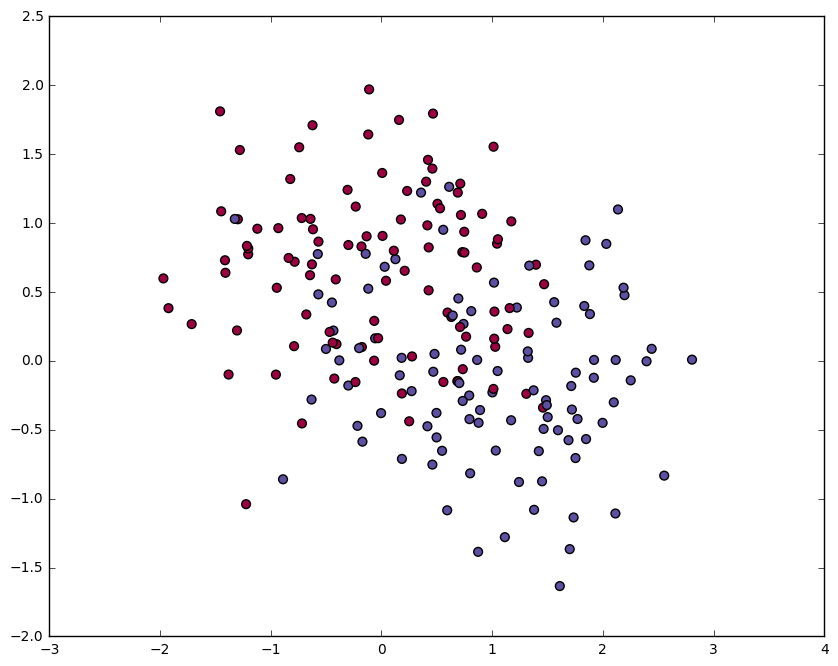

In [13]:
# Generate a dataset and plot it

# The seed allow us to predict random numbers, it's easier to debug
np.random.seed(0)

# change the levle of noise to see the perfomance of the classfier 
X, y = sklearn.datasets.make_moons(200, noise=0.50)

# The dataset is labeled by 0 and 1
# So we can plot by using matplotlib

plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [14]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

Now the FeedForward part we did before: 

In [15]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

We need a way to evaluate our model. In order to do this, we have to create a function that calculating the loss function.

In [16]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss, cross entropy loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    return 1./num_examples * data_loss

Then the training part:

In [17]:
def build_model(nn_hdim, num_passes=4000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 100 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

Ok! Let's try our code!!

In [18]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Loss after iteration 0: 0.498313
Loss after iteration 100: 0.451253
Loss after iteration 200: 0.417712
Loss after iteration 300: 0.404227
Loss after iteration 400: 0.401622
Loss after iteration 500: 0.400568
Loss after iteration 600: 0.399992
Loss after iteration 700: 0.399598
Loss after iteration 800: 0.399301
Loss after iteration 900: 0.399064
Loss after iteration 1000: 0.398868
Loss after iteration 1100: 0.398703
Loss after iteration 1200: 0.398564
Loss after iteration 1300: 0.398444
Loss after iteration 1400: 0.398341
Loss after iteration 1500: 0.398251
Loss after iteration 1600: 0.398172
Loss after iteration 1700: 0.398103
Loss after iteration 1800: 0.398041
Loss after iteration 1900: 0.397985
Loss after iteration 2000: 0.397934
Loss after iteration 2100: 0.397888
Loss after iteration 2200: 0.397845
Loss after iteration 2300: 0.397805
Loss after iteration 2400: 0.397768
Loss after iteration 2500: 0.397733
Loss after iteration 2600: 0.397699
Loss after iteration 2700: 0.397667
Loss

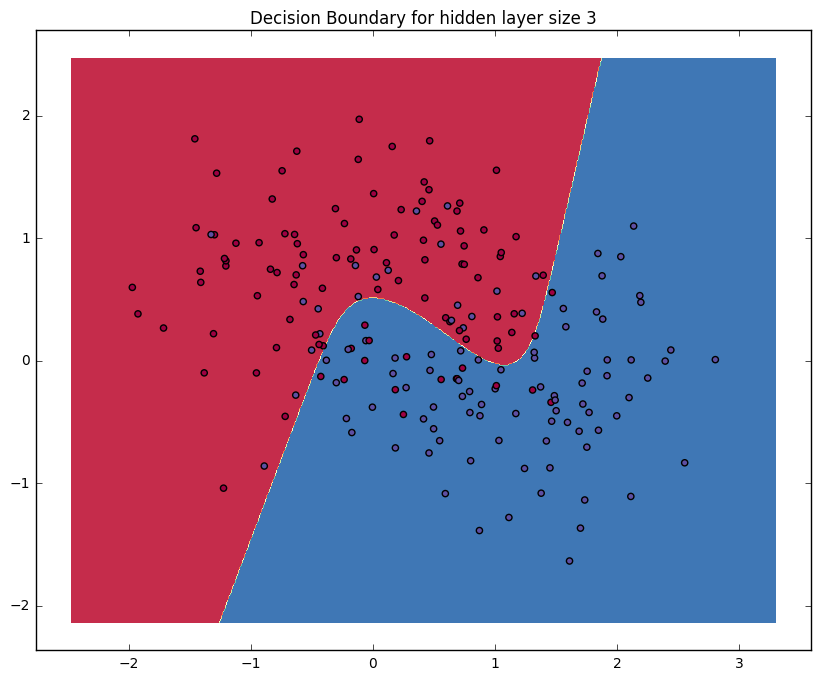

In [19]:
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

As you can see, our NN classified our dataset quite well. depends on the noise. 
Now we can try different size of hidden layer. 

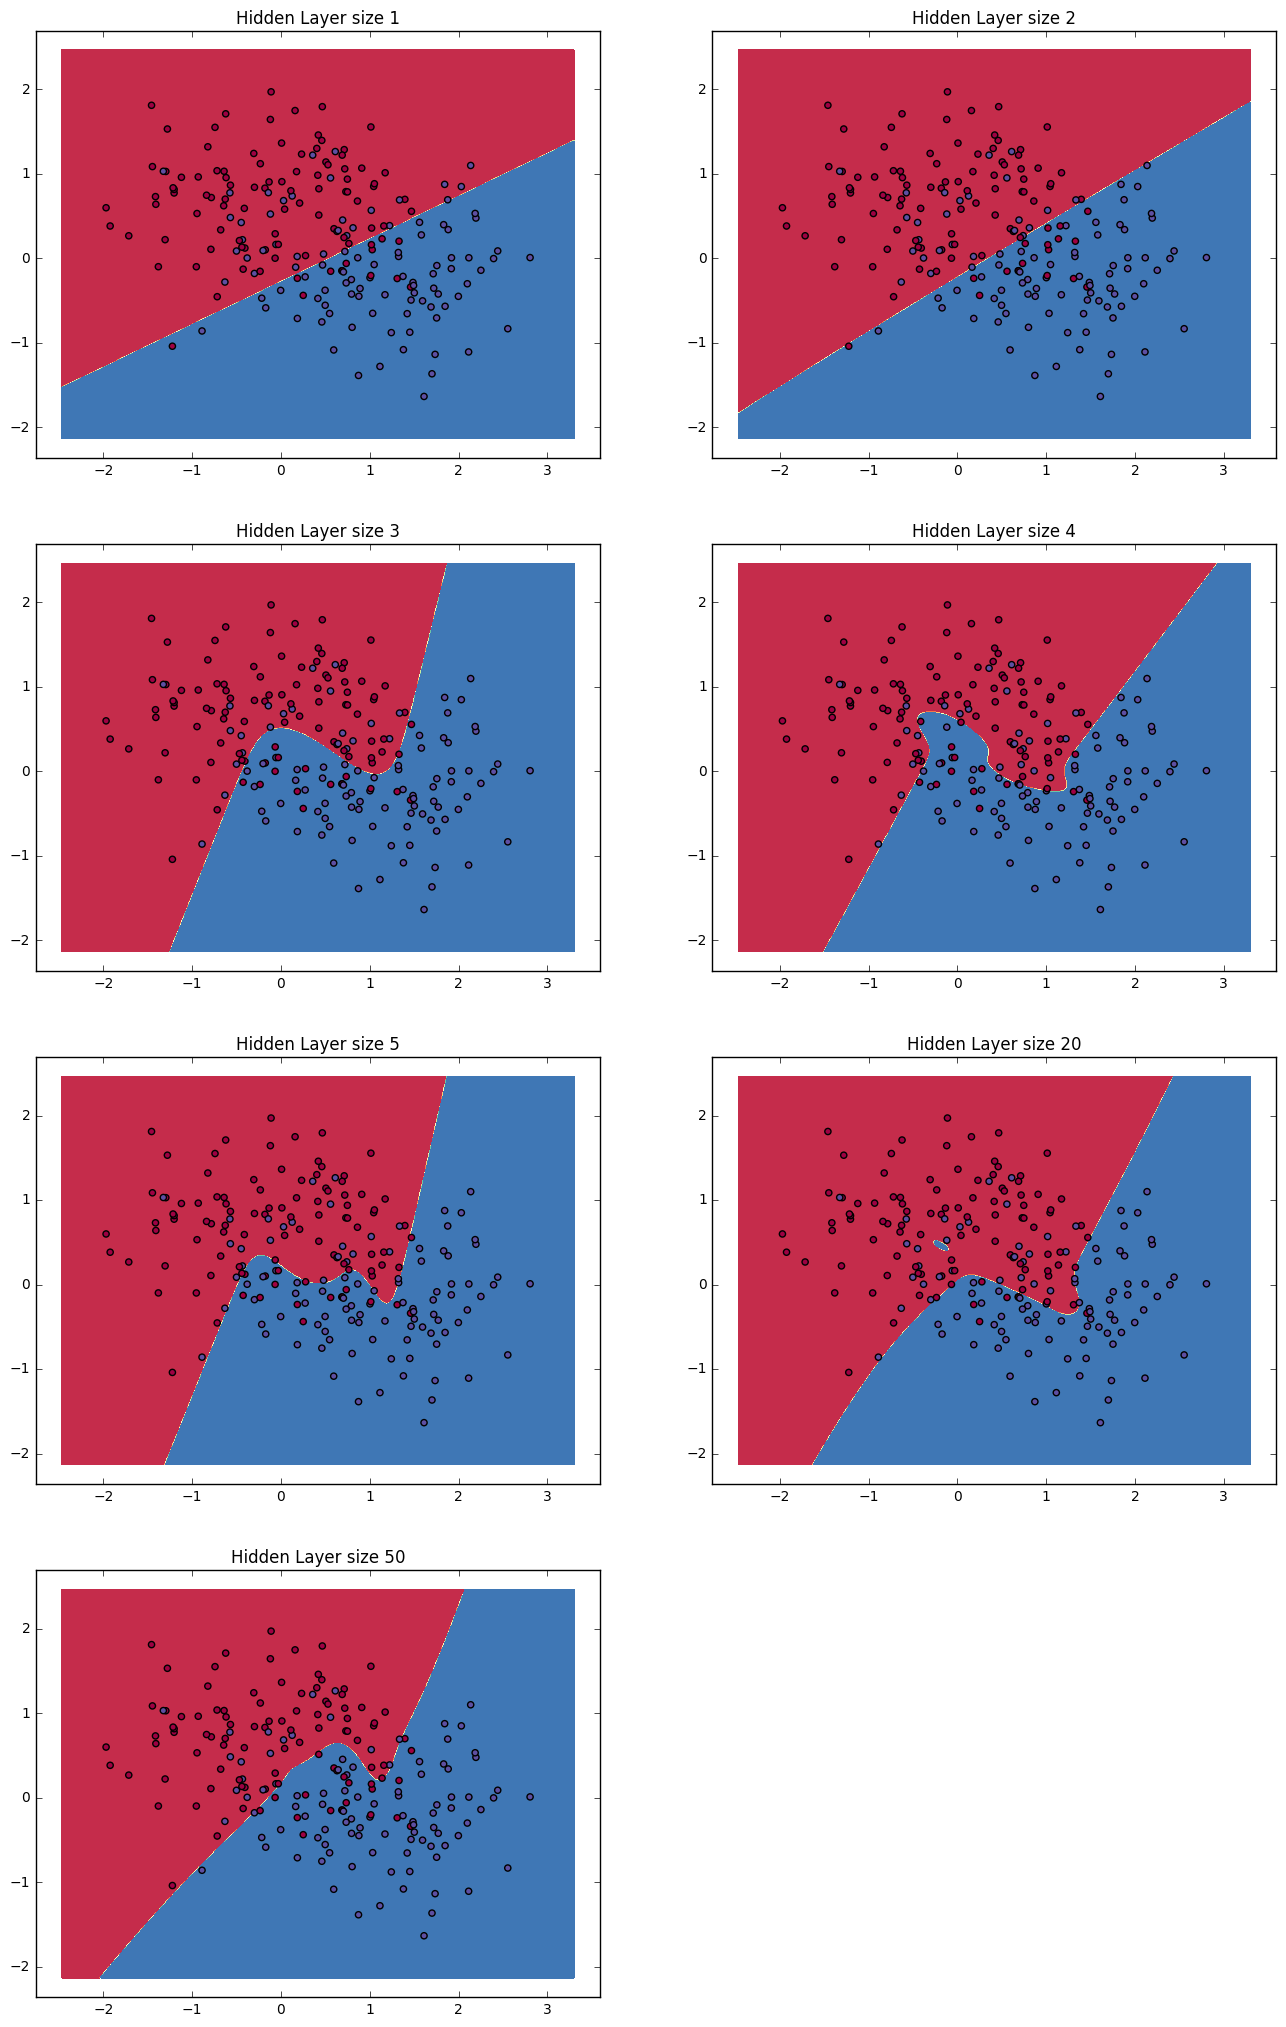

In [20]:
plt.figure(figsize=(16, 32))
# comparing number of neurons needed in the hiden layers  
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()